In [1]:
import numpy as np
from numpy import genfromtxt
import time

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Reshape
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,Conv1DTranspose
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM, Bidirectional,ConvLSTM1D
from keras.layers import TimeDistributed,GaussianNoise
from keras.layers import RepeatVector
from keras.layers import Input,LeakyReLU,LayerNormalization
from tqdm import tqdm


from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split



In [2]:
from sklearn.preprocessing import MinMaxScaler

##################################################################################
data_size=173
num_parameters=9
BATCH_SIZE = 64*4
in_size=3
A=1
X=np.zeros((data_size,num_parameters))

for i in range(data_size):
  my_data = genfromtxt("D:\Research_work\My_covid_research\dataset_preprocessing\parameter_estim\output\parameters_ "+str(i+1)+" .csv", delimiter=',')
  X[i,:]=my_data[0:num_parameters]

  
p = np.random.permutation(len(X))
X=X[p]
scaler=MinMaxScaler()
X_s=scaler.fit_transform(X)
X_s=X.reshape(X.shape[0],X.shape[1],1)
train_dataset = tf.data.Dataset.from_tensor_slices((X_s))
train_dataset = train_dataset.batch(BATCH_SIZE)



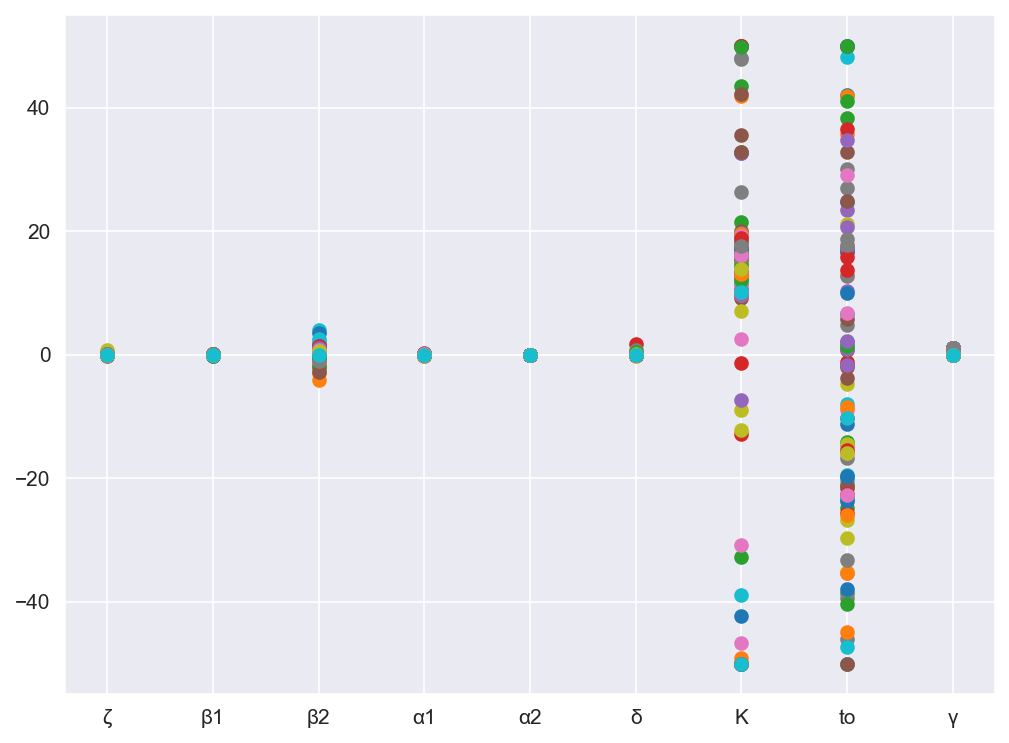

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from itertools import chain
import seaborn as sns
sns.set_style('darkgrid')

figure(figsize=(8, 6), dpi=150)
for i in range (100):
    x=[1,2,3,4,5,6,7,8,9]
    greek_codes   = chain(range(0x370, 0x3e2), range(0x3f0, 0x400))
    greek_symbols = (chr(c) for c in greek_codes)
    greek_letters = [c for c in greek_symbols if c.isalpha()]
    my_letters=greek_letters[51:61]
    para_names=[my_letters[5],my_letters[1]+str(1),my_letters[1]+str(2),my_letters[0]+str(1),my_letters[0]+str(2),my_letters[3],'K','to',my_letters[2]]
    plt.scatter(x,X[i,:])
    plt.xticks(x,para_names, rotation='horizontal')
    plt.grid(True)

In [26]:


# Custom activation function
from keras.layers import Activation,Bidirectional,UpSampling1D
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.regularizers import l2



def custom_activation(x):
    return 1*(x)

get_custom_objects().update({'custom_activation': Activation(custom_activation)})

class Equator(keras.layers.Layer):
    def __init__(self, units=15, input_dim=1):
        super(Equator, self).__init__()
        # b_init = tf.zeros_initializer()
        # self.b = tf.Variable(
        #     initial_value=b_init(shape=(input_dim, units), dtype="float32"), trainable=True
        # )
        self.b = self.add_weight(shape=(1,num_parameters ), initializer=tf.random_uniform_initializer(minval=0, maxval=20.),trainable=True)

    def call(self, inputs):
        mat_form=inputs
        # mat_form=tf.expand_dims(mat_form, axis=0, name=None)
        # mat_form=tf.reverse(
        #     mat_form, axis=1, name=None
        # )
        return self.b*mat_form

    def get_config(self):
        config = super().get_config()
        config.update({
            "b": self.b,
        })
        return config


#Generator Model
def make_generator_model():
    model = Sequential()
    model.add(tf.keras.layers.Reshape((in_size,1)))
    # model.add(Input(shape=[in_size,1]))


    # model.add(Bidirectional(LSTM(64, return_sequences=True)))

    model.add(Conv1DTranspose(filters=128, kernel_size=3, use_bias=False,activation='linear'))
    model.add(BatchNormalization())
    # model.add(LeakyReLU())
    # model.add(GaussianNoise(0.1))
    model.add(Conv1DTranspose(filters=64, kernel_size=3, use_bias=False,activation='linear'))
    model.add(BatchNormalization())
    # # model.add(GaussianNoise(0.1))
    # # # model.add(LeakyReLU())
    model.add(Conv1DTranspose(filters=32, kernel_size=5, use_bias=False,activation='linear'))
    model.add(BatchNormalization())
    # # model.add(GaussianNoise(0.1))
    # model.add(Conv1DTranspose(filters=16, kernel_size=1, strides=1, padding='same', use_bias=False,activation='linear'))
    # model.add(BatchNormalization())
    # model.add(GaussianNoise(0.1))
    # model.add(Conv1DTranspose(filters=4, kernel_size=4, strides=1, padding='same',activation='tanh'))
    # model.add(GaussianNoise(0.1))
    # model.add(LeakyReLU())
    
    # model.add(UpSampling1D(2))
    #
    # model.add(layers.Conv1D(filters=32, kernel_size=16, strides=1, padding='same'))
    # model.add(layers.LeakyReLU())
    # #
    # model.add(layers.Conv1D(filters=16, kernel_size=16, strides=1, padding='same'))
    # model.add(layers.LeakyReLU())
    # # model.add(keras.layers.LayerNormalization(epsilon=0.001))
    # model.add(Conv1D(filters=16*2, kernel_size=1,
    #         strides=1, padding="causal",
    #         activation="relu"))
    # model.add(Conv1D(filters=16*2, kernel_size=1,
    #     strides=1, padding="causal",
    #     activation="relu"))
    # model.add(LSTM(units=10,return_sequences=True))
    # model.add(LSTM(units=10,return_sequences=True))
    model.add(Flatten())
    # model.add(Dense(256,activation='linear'))

    model.add(Dense(num_parameters, activation='linear'))
    # model.add(Activation(custom_activation, name='SpecialActivation'))
    # model.add(Equator())
    # model.add(Activation(custom_activation, name='SpecialActivation'))
    return model

# Descriminator model


def make_discriminator_model():
    model = Sequential()
    
    model.add(Conv1D(filters=32, kernel_size=3,use_bias=False, activation='linear', input_shape=[num_parameters,1]))
    model.add(BatchNormalization())
    # model.add(GaussianNoise(0.1))
    # model.add(Conv1D(filters=64, kernel_size=3,use_bias=False,activation='linear'))
    # model.add(BatchNormalization())
    # model.add(GaussianNoise(0.1))
    # # model.add(Dropout(0.1))
    # model.add(Conv1D(filters=128, kernel_size=3,use_bias=False,activation='linear'))
    # model.add(BatchNormalization())
    # model.add(GaussianNoise(0.1))
    # model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding="causal",use_bias=False,activation='tanh'))
    # model.add(LeakyReLU())
    # model.add(BatchNormalization())
    # model.add(Conv1D(filters=128, kernel_size=1, strides=1, padding="causal",activation='tanh'))
    # model.add(Conv1D(filters=64, kernel_size=4, strides=2, padding="causal",activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    # model.add(Dense(100, activation='tanh'))
    # model.add(Dropout(0.9))
    model.add(Dense(1, activation='sigmoid'))
    # model.add(Equator())
    return model

In [27]:


#################################################################################
#          Prepare metrics for logging
#################################################################################

disc_losses = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)
disc_losses_list = []

### discriminator accuracy ###
fake_disc_accuracy = tf.keras.metrics.BinaryAccuracy('fake_disc_accuracy')
real_disc_accuracy = tf.keras.metrics.BinaryAccuracy('real_disc_accuracy')
fake_disc_accuracy_list, real_disc_accuracy_list = [], []

### generator loss ###
# gen_log_dir = 'logs/gradient_tape/gen_loss'
# gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
gen_losses = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
gen_losses_list = []


#################################################################################
#          Prepare loss functions and optimizers
#################################################################################

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)


In [28]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [29]:
noise_dim = in_size
num_examples_to_generate = data_size
disc_steps = 1

seed = A*tf.random.normal([num_examples_to_generate, noise_dim])


@tf.function
def train_step(real):
    noise = A*tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)

        real_output = discriminator(real, training=True)
        fake_output = discriminator(generated, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    ### for tensorboard ###
    disc_losses.update_state(disc_loss)
    fake_disc_accuracy.update_state(tf.zeros_like(fake_output), fake_output)
    real_disc_accuracy.update_state(tf.ones_like(real_output), real_output)
    #######################
    
    with tf.GradientTape() as gen_tape:
        generated = generator(noise, training=True)
        fake_output = discriminator(generated, training=True)

        gen_loss = generator_loss(fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    ### for tensorboard ###
    gen_losses.update_state(gen_loss)
    #######################


def train(dataset, epochs):
    for epoch in tqdm(range(epochs)):
    
        for batch in dataset:
            train_step(batch)
            
        disc_losses_list.append(disc_losses.result().numpy())
        gen_losses_list.append(gen_losses.result().numpy())
        
        fake_disc_accuracy_list.append(fake_disc_accuracy.result().numpy())
        real_disc_accuracy_list.append(real_disc_accuracy.result().numpy())
            
        disc_losses.reset_states()        
        gen_losses.reset_states()
        
        fake_disc_accuracy.reset_states()
        real_disc_accuracy.reset_states()
        
EPOCHS=2000
train(train_dataset, EPOCHS)


100%|██████████| 2000/2000 [01:04<00:00, 31.02it/s]


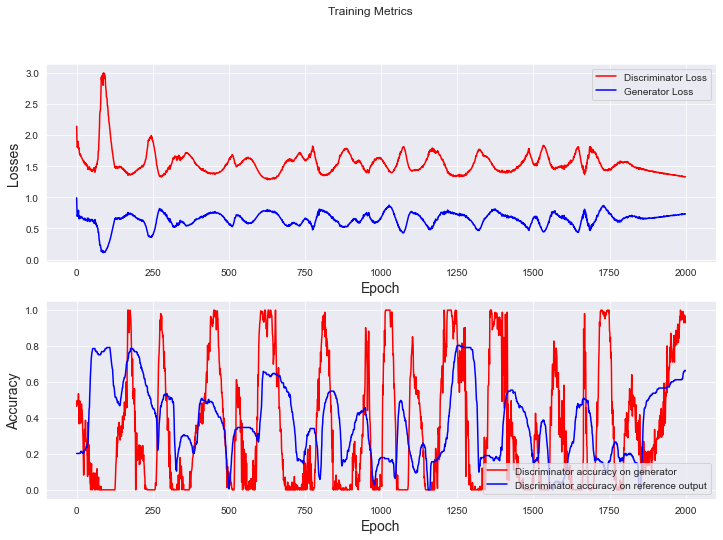

In [30]:
# %reload_ext tensorboard
# %tensorboard --logdir logs/gradient_tape

fig, axes = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Losses", fontsize=14)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].plot(disc_losses_list, color='red')
axes[0].plot(gen_losses_list, color='blue')
axes[0].legend(['Discriminator Loss', 'Generator Loss'], loc='upper right')

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(fake_disc_accuracy_list, color='red')
axes[1].plot(real_disc_accuracy_list, color='blue')
axes[1].legend(['Discriminator accuracy on generator', 'Discriminator accuracy on reference output'], loc='lower right')
plt.show()

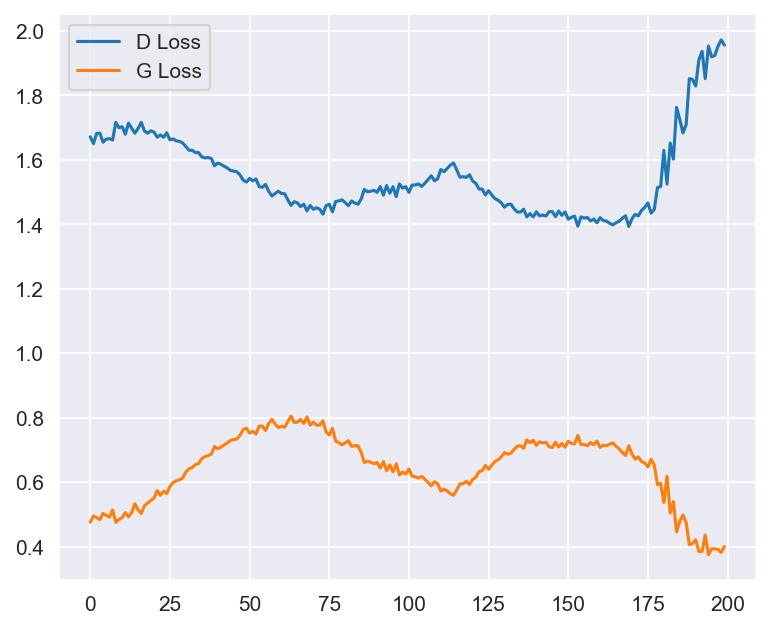

In [9]:

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=(6, 5), dpi=150)
escape=800-40

plt.plot(disc_losses_list[100:300],label='D Loss')
plt.plot( gen_losses_list[100:300],label='G Loss')
plt.legend()


In [78]:
# saving my pretty models
generator.save('par_generator4.h5')
discriminator.save('par_discriminator4.h5')

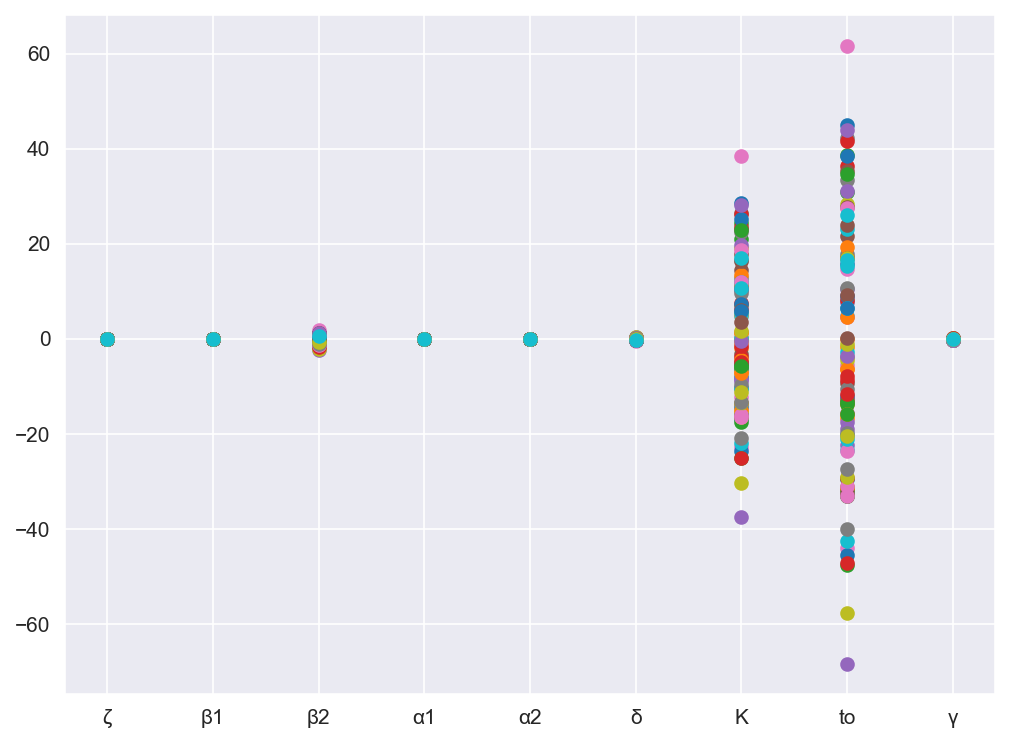

In [32]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from itertools import chain
import seaborn as sns
sns.set_style('darkgrid')

seed=tf.random.normal([2000,in_size])
xx=generator.predict(seed)
xx=scaler.inverse_transform(xx)/20

figure(figsize=(8, 6), dpi=150)
for i in range (100):
    x=[1,2,3,4,5,6,7,8,9]
    greek_codes   = chain(range(0x370, 0x3e2), range(0x3f0, 0x400))
    greek_symbols = (chr(c) for c in greek_codes)
    greek_letters = [c for c in greek_symbols if c.isalpha()]
    my_letters=greek_letters[51:61]
    para_names=[my_letters[5],my_letters[1]+str(1),my_letters[1]+str(2),my_letters[0]+str(1),my_letters[0]+str(2),my_letters[3],'K','to',my_letters[2]]
    plt.scatter(x,xx[i,:])
    plt.xticks(x,para_names, rotation='horizontal')
    plt.grid(True)


np.savetxt("parameter_generated2.csv", xx, delimiter=",")

In [196]:
# L_algebra=4000
# Xer=[]
# prob_record=[]
# seed=A*tf.random.normal([L_algebra,in_size])
# X_p=generator.predict(seed)*Lamby
# my_model = keras.models.load_model("secondary_unit.h5")
# my_dat=[]
# for i in range(L_algebra):
#     x=X_p[i,:]
#     x=x.reshape(3,5)
#     for j in range(5):
#         if np.min(x[:,j])<0:
#             x[:,j]=x[:,j]+np.min(x[:,j])

#     buffer=np.expand_dims(x, axis=0)
#     out=my_model.predict(buffer)
#     prob_record.append(np.mean(out))
#     if np.mean(out)>=0.99:
#         my_dat.append(x)

# if len(my_dat)>0:
#     my_dat_np=np.array(my_dat)
#     X=np.concatenate(my_dat_np,axis=0)
#     np.savetxt("D:\Research_work\covid_parameters\covid_data_collection_and_smoothing\paramter_estim\deep_learning_extension\GAN_tensorflow\state_data_tf3.csv",X ,delimiter=",")

In [197]:
# figure(figsize=(8, 6), dpi=150)
# plt.plot(prob_record)
# plt.plot(0.99*np.ones(L_algebra),'r')
# plt.xlabel('Samples')
# plt.ylabel('Probability')

In [198]:
# len(my_dat)

In [199]:
# sum(prob_record)/len(prob_record)